# Results
In this notebook we are going to show our analysis done on RateBeer, BeerAdvocate and MatchedBeers datasets. <br><br>
Others important notebooks are in:
- `data/processing/`: here we have all the code needed to process the data and make them into a format suitable for our purposes.
- `data/cleaning`: here we have all the code needed for the very preliminary analysis, data cleaning and data filling. 

The data are firstly processed with the code in the `data/processing/` folder and then cleaned with the code in the `data/cleaning/` folder. Finally, the cleaned data are used in this notebook for the analysis.


## Preliminary analysis
In this notebook we mostly focused on general analysis of the data. We mostly focused on performing temporal and spatial analysis of the data, ensured that all the needed data were available and finally that the data were consistent and we'll show the results that we obtained. <br><br>
We plan to do a more in-depth analysis in the next milestone, where we will focus on in-depth analysis of the data.

### Import all the required libraries

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
import numpy as np
import tqdm
import os
from src.utils.data_desc import *

### RateBeer
#### Data loading

In [2]:
df_beers = pl.read_parquet("./data/RateBeer/processed/beers.pq")
df_breweries = pl.read_parquet("./data/RateBeer/processed/breweries.pq")
df_users = pl.read_parquet("./data/RateBeer/processed/users.pq")
df_ratings_no_text = pl.read_parquet("./data/RateBeer/processed/ratings_no_text.pq")

#### Data analysis

Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

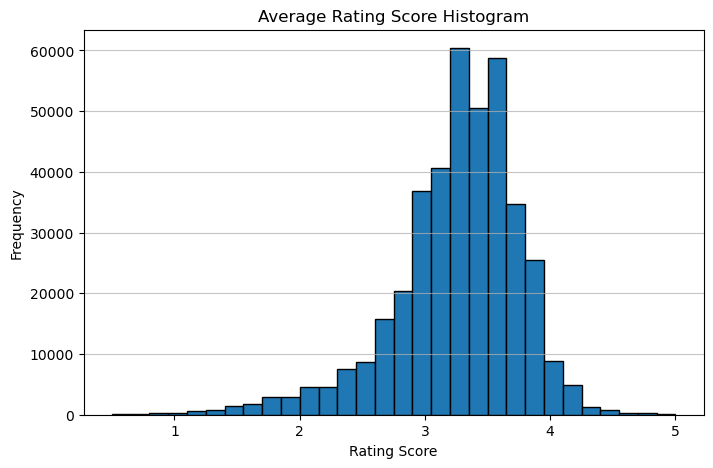

In [3]:
# Convert the 'rating_score_avg' column to a list for plotting
rating_score_avg = df_beers.select(pl.col("rating_score_avg").filter(pl.col("rating_score_avg").is_not_null())).to_series().to_list()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(rating_score_avg, bins=30, edgecolor='black')
plt.title('Average Rating Score Histogram')
plt.xlabel('Rating Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Here we see that the rating_score_avg seems to resemble a normal distribution. 

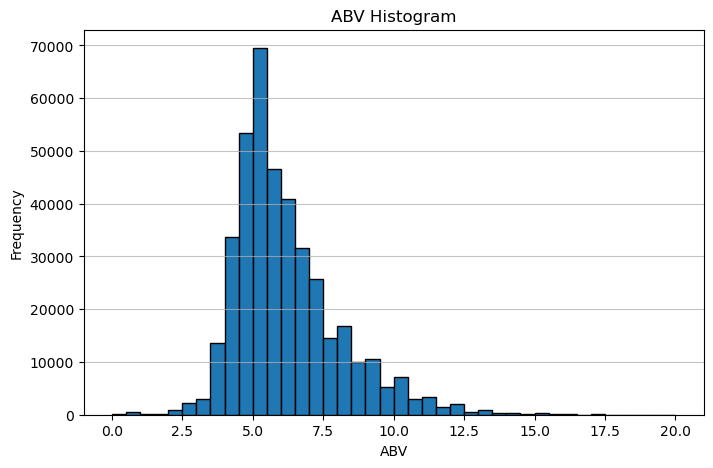

In [4]:
# Sample data selection
abv = df_beers.select(pl.col("abv").filter(pl.col("abv").is_not_null())).to_series().to_list()

# Plot histogram with more bins between 0 and 10
plt.figure(figsize=(8, 5))
plt.hist(abv, bins=40, range=(0, 20), edgecolor='black')  # Increase number of bins for better resolution
plt.title('ABV Histogram')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


Just like in the BeerAdvocate dataset, the ABV seems at first sight to follow a right-skewed distribution. There are very few beers with less than 4% alcohol.

The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

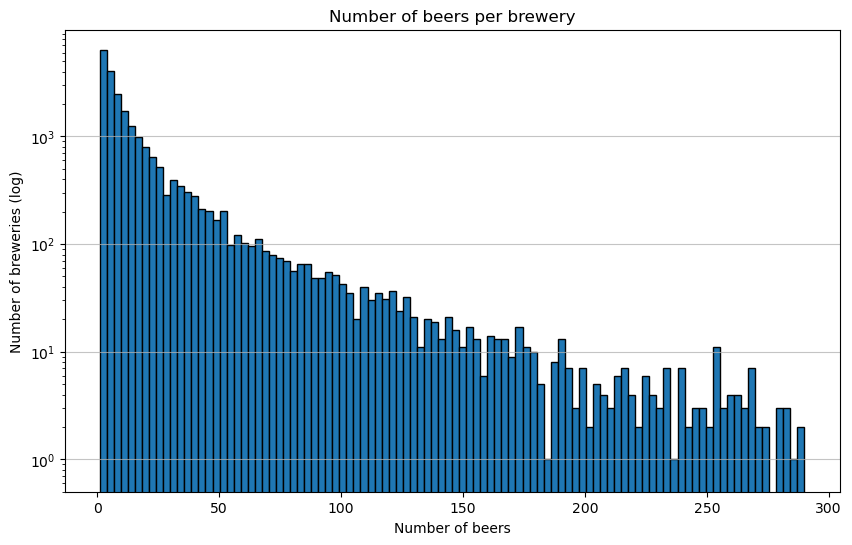

In [5]:
# Plot an histogram with the number of beers per brewery
values = df_breweries['beers_count'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["beers_count"], bins=100, weights=values["count"], edgecolor='black')
plt.yscale('log')
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log)')
plt.title('Number of beers per brewery')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

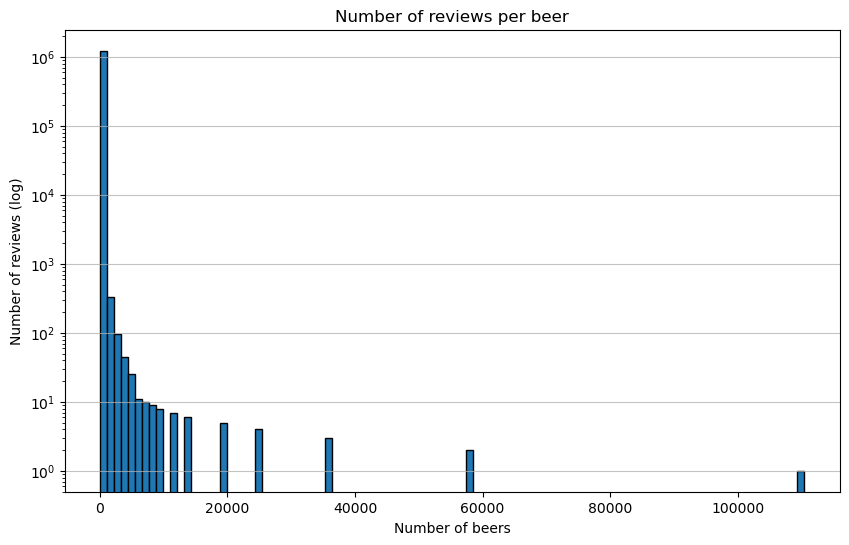

In [6]:
# Plot an histogram with the number of reviews for each beer
values = df_beers['nbr_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["count"], bins=100, weights=values["nbr_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of beers')
plt.title('Number of reviews per beer')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

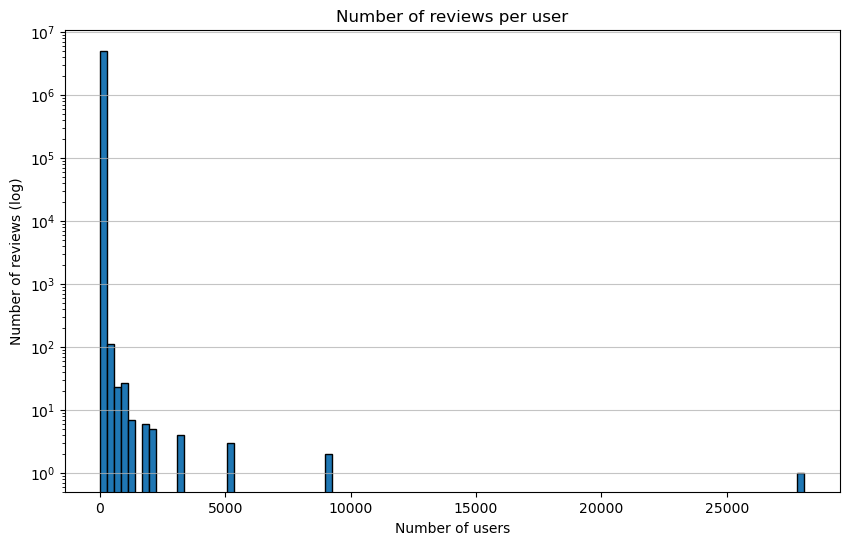

In [7]:
# Plot an histogram with the number of reviews for each user
values = df_users['number_of_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["count"], bins=100, weights=values["number_of_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of users')
plt.title('Number of reviews per user')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

To verify if we are actually dealing with power laws, we can plot the plots again, but now as a probability density function on a log-log scale.

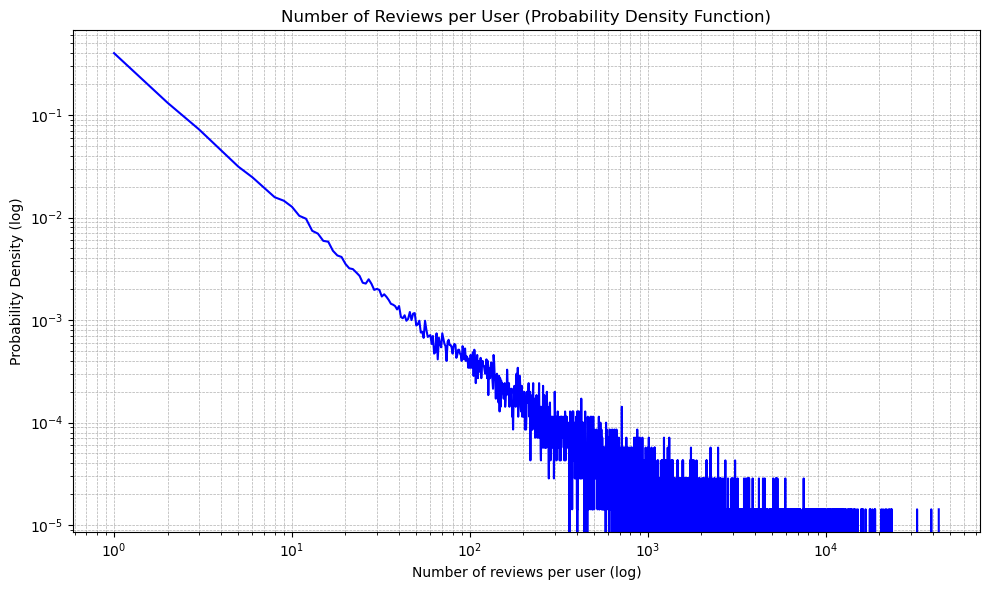

In [8]:
values = df_users['number_of_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values['number_of_ratings'].min(), values['number_of_ratings'].max() + 1)
values = values.set_index('number_of_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of Reviews per User (Probability Density Function)')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

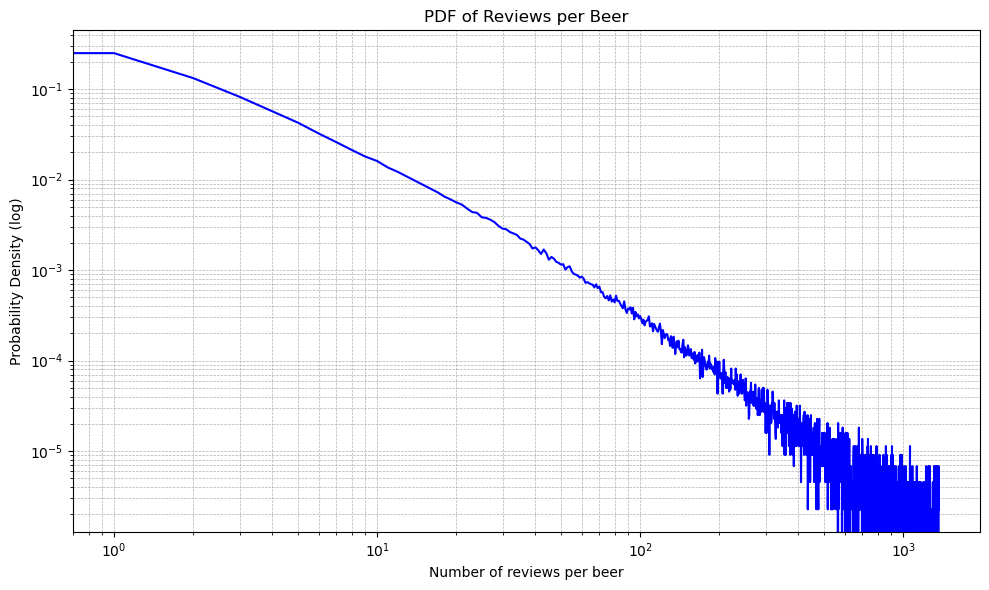

In [9]:
values = df_beers['nbr_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('nbr_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per beer')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Reviews per Beer')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Here, just like in the BeerAdvocate dataset, these are fairly straight lines, so we are dealing with power laws. This has the same implications as described in that notebook.

But also here we can see that the amount of beers per brewery does not follow a power law.

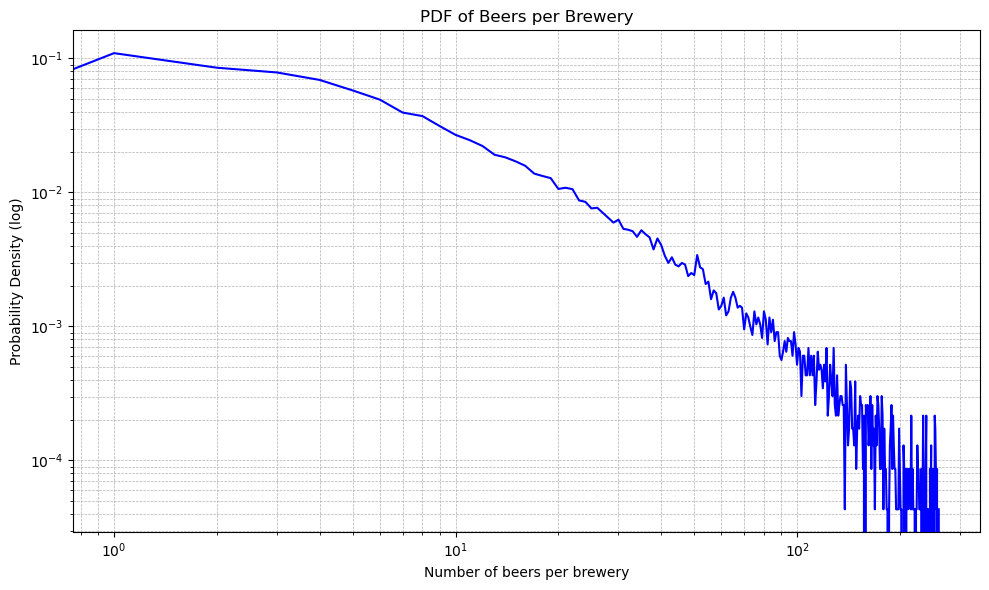

In [10]:
values = df_breweries['beers_count'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('beers_count').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

We can now do some initial exploration into potential correlations in our dataframe.

In [11]:
df_beers_corr = df_beers.select([
    'abv', 
    'rating_score_avg', 
    'nbr_interactions', 
])

In [12]:
correlation_matrix = df_beers_corr.to_pandas().dropna().corr()

In [13]:
correlation_matrix

,abv,rating_score_avg,nbr_interactions
abv,1.000000,0.364346,0.049709
rating_score_avg,0.364346,1.000000,0.016294
nbr_interactions,0.049709,0.016294,1.000000


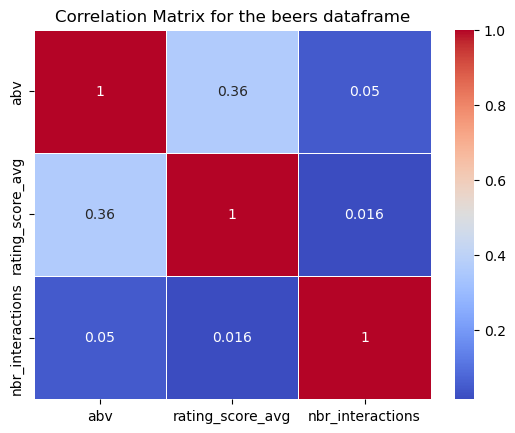

In [14]:
# plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for the beers dataframe')
plt.show()

Here, just as with BeerAdvocate, we have a similar correlation between ABV and the average rating. This is defined as a weak correlation, but it is still definitely important. This is likely because users of the platform are experienced drinkers and prefer heavier beers. 

#### Geographical analysis

##### User locations by country

As can be seen in the graph below, the largest continent in terms of user base is by far the North America.

Europe comes in second, and South America, Asia and Australia also have sizable audiences. 

Africa and Antarctica both have very few users. The Middle-East is also very devoid of any users. This makes sense, as many countries here have laws that ban the production and consumption of alcohol. 

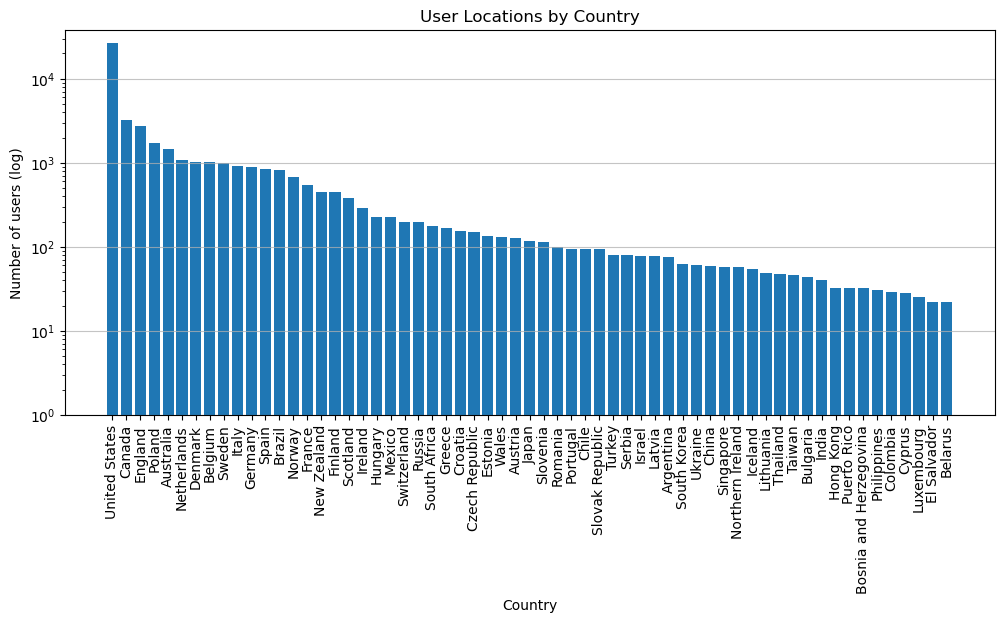

In [15]:
# Convert the polaris datastructure into a pandas dataframe
df_users_pd = df_users.to_pandas()

# Extract country names (split by ', ' and take the last part)
df_users_pd['country'] = df_users_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
country_counts = df_users_pd['country'].value_counts().reset_index()
country_counts_filtered = country_counts[country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 5))
plt.bar(country_counts_filtered['country'], country_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of users (log)')
plt.yscale('log')
plt.title('User Locations by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

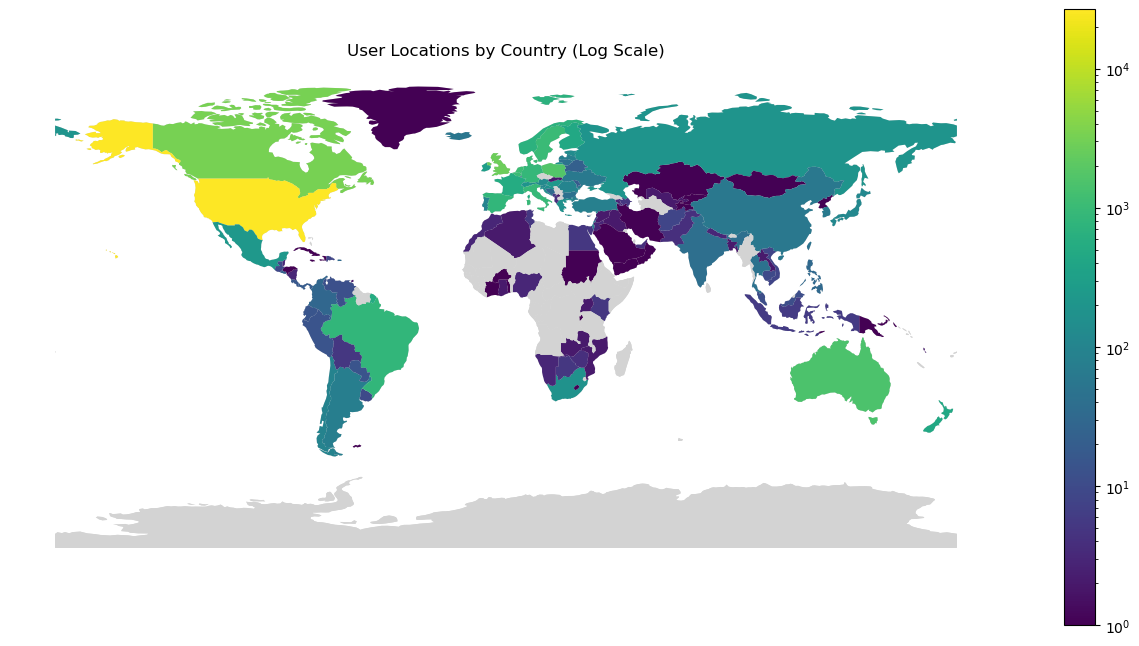

In [16]:
# Do some renaming of country names to match the map dataset
country_counts.loc[country_counts['country'] == 'United States', 'country'] = 'United States of America'
country_counts.loc[country_counts['country'] == 'England', 'country'] = 'United Kingdom'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('User Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Brewery locations by country

In the following two graphs we can see geographical location of breweries. This seems to be quite similar to the location of the users, but a bit flatter. This is likely because users will upload beers they have tried while traveling, and there is a ceiling to how many breweries you can enter into the database, as there are only so many breweries in a given country. 

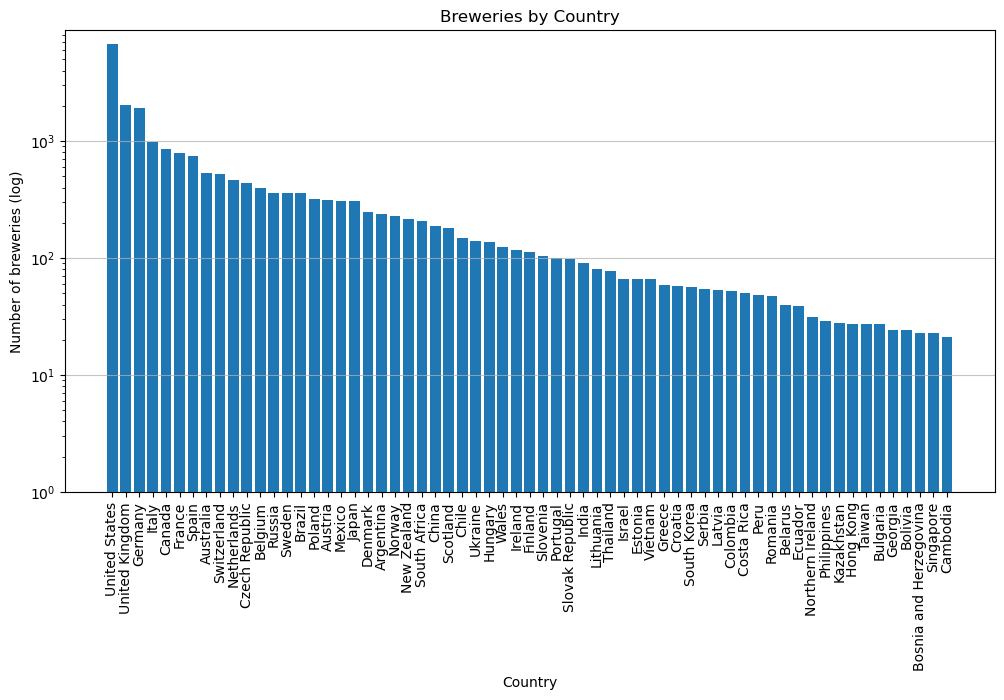

In [17]:
# Convert the polaris datastructure into a pandas dataframe
df_breweries_pd = df_breweries.to_pandas()
df_breweries_pd.loc[df_breweries_pd['location'] == 'England', 'location'] = 'United Kingdom'

# Extract country names (split by ', ' and take the last part)
df_breweries_pd['country'] = df_breweries_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
breweries_country_counts = df_breweries_pd['country'].value_counts().reset_index()
breweries_counts_filtered = breweries_country_counts[breweries_country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 6))
plt.bar(breweries_counts_filtered['country'], breweries_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.yscale('log')
plt.ylabel('Number of breweries (log)')
plt.title('Breweries by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

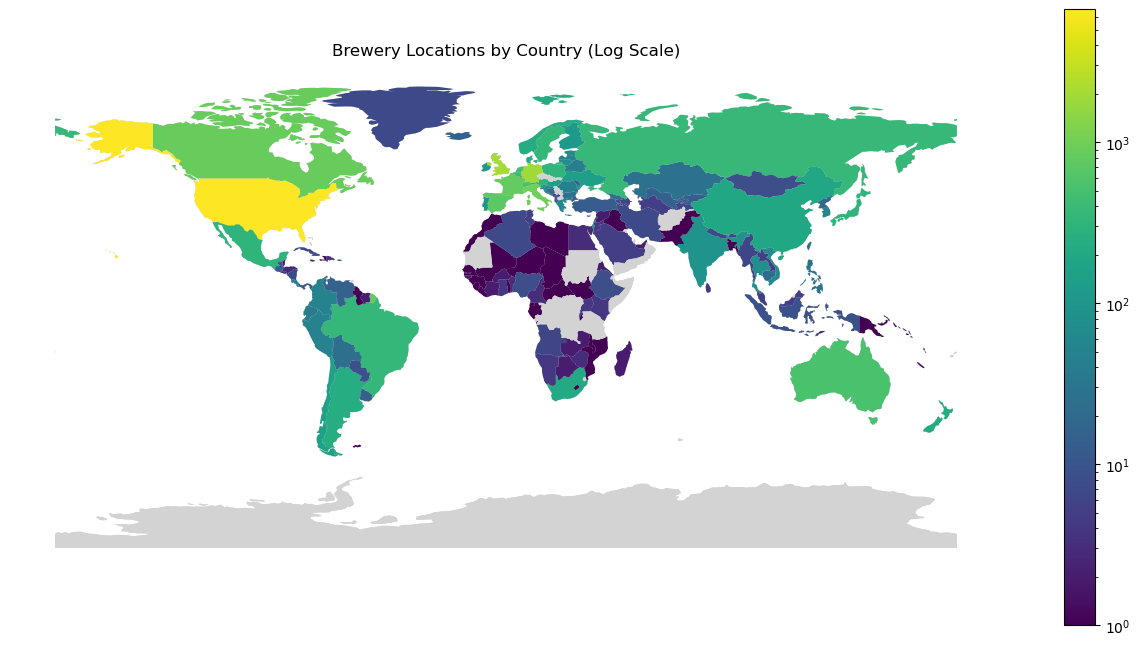

In [18]:
# Do some renaming of country names to match the map dataset
breweries_country_counts.loc[breweries_country_counts['country'] == 'United States', 'country'] = 'United States of America'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(breweries_country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('Brewery Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

### BeerAdvocate

#### Loading the fixed data

In [19]:
df_beers = pl.read_parquet("./data/BeerAdvocate/processed/beers.pq")
df_breweries = pl.read_parquet("./data/BeerAdvocate/processed/breweries.pq")
df_users = pl.read_parquet("./data/BeerAdvocate/processed/users.pq")
df_ratings_no_text = pl.read_parquet("./data/BeerAdvocate/processed/ratings_no_text.pq")

### Data distribution

Now we can take a look at what our data looks like visually. Taking a look at data can often reveal hidden patterns or distributions that are not easily visible while just looking at the numbers.

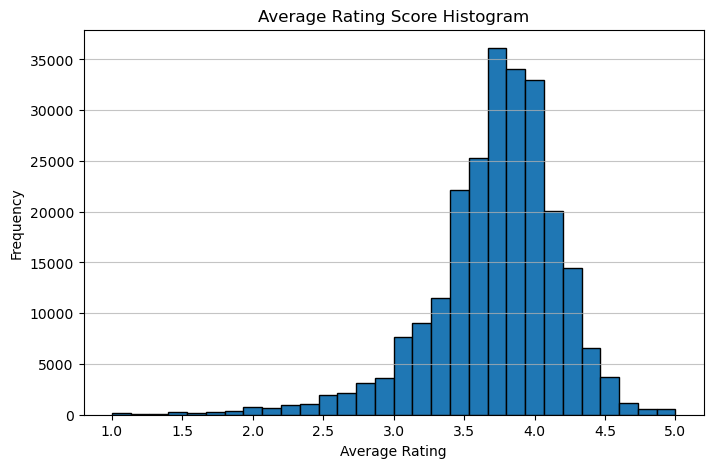

In [20]:
# Convert the 'rating_score_avg' column to a list for plotting
rating_score_avg = df_beers.select(pl.col("rating_score_avg").filter(pl.col("rating_score_avg").is_not_null())).to_series().to_list()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(rating_score_avg, bins=30, edgecolor='black')
plt.title('Average Rating Score Histogram')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

The average score is normally distributed. Most of the beers get a score in the high threes or the low fours. 

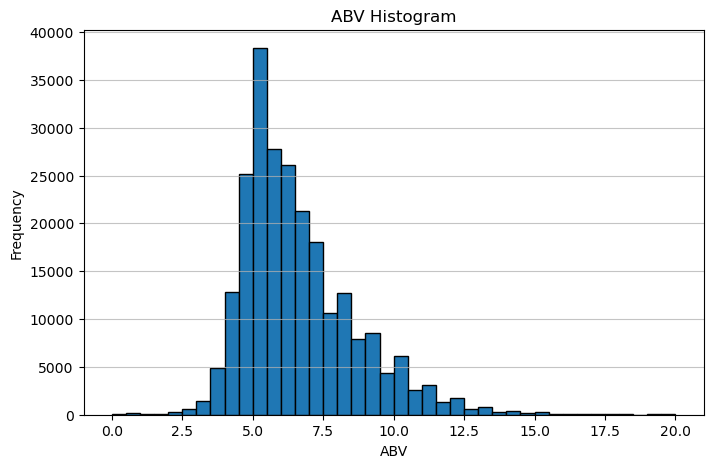

In [21]:
# Sample data selection
abv = df_beers.select(pl.col("abv").filter(pl.col("abv").is_not_null())).to_series().to_list()

# Plot histogram with more bins between 0 and 10
plt.figure(figsize=(8, 5))
plt.hist(abv, bins=40, range=(0, 20), edgecolor='black')  # Increase number of bins for better resolution
plt.title('ABV Histogram')
plt.xlabel('ABV')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()


The ABV on the other hand, seems at first sight to follow a right-skewed distribution. There are very few beers with less than 4% alcohol.

The following three plots are for the number of beers per brewery, the number of reviews per beer and the number of reviews per user. All three of them show a lot of entries in the beginning, and a few entries with very large numbers. This seems to suggest a power law. We can investigate this.

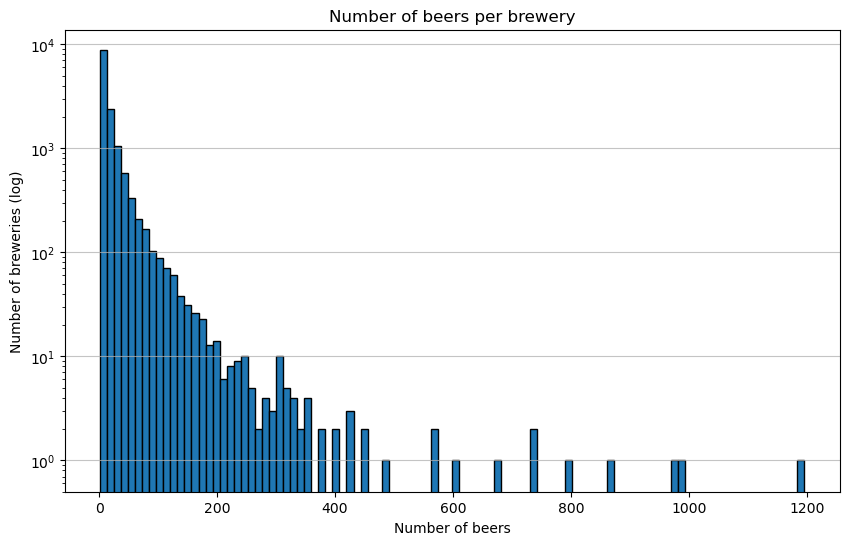

In [22]:
# Plot an histogram with the number of beers per brewery
values = df_breweries['beers_count'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.hist(values["beers_count"], bins=100, weights=values["count"], edgecolor='black')
plt.yscale('log')
plt.xlabel('Number of beers')
plt.ylabel('Number of breweries (log)')
plt.title('Number of beers per brewery')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

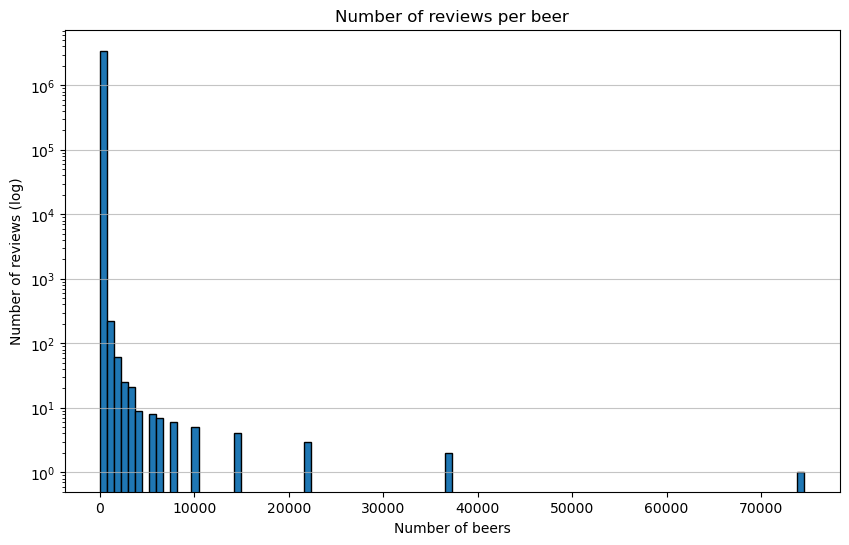

In [23]:
# Plot an histogram with the number of reviews for each beer
values = df_beers['nbr_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
# plt.hist(values["nbr_ratings"], bins=100, weights=values["count"], edgecolor='black')
plt.hist(values["count"], bins=100, weights=values["nbr_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of beers')
plt.title('Number of reviews per beer')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

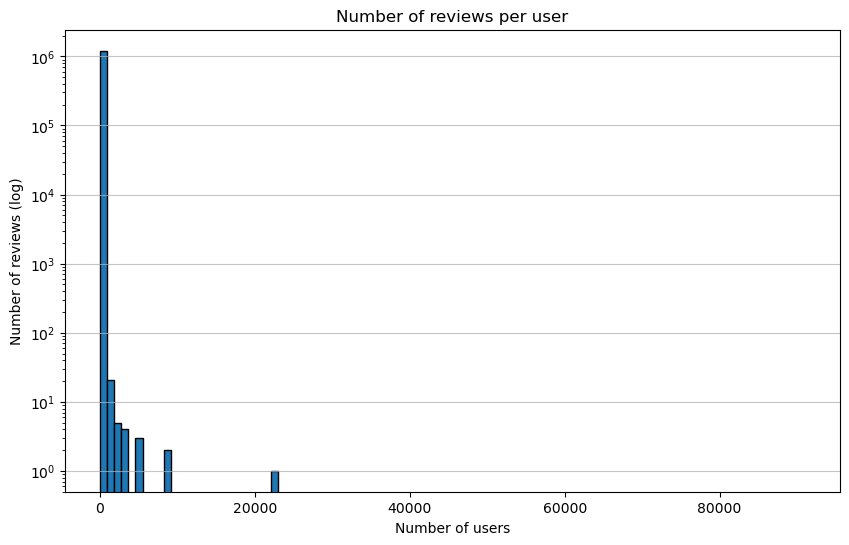

In [24]:
# Plot an histogram with the number of reviews for each user
values = df_users['nbr_ratings'].value_counts()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
# plt.hist(values["nbr_ratings"], bins=100, weights=values["count"], edgecolor='black')
plt.hist(values["count"], bins=100, weights=values["nbr_ratings"], edgecolor='black')
plt.yscale('log')
plt.ylabel('Number of reviews (log)')
plt.xlabel('Number of users')
plt.title('Number of reviews per user')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=0.5)
plt.show()

To verify if we are actually dealing with power laws, we can plot the plots again, but now as a probability density function on a log-log scale.

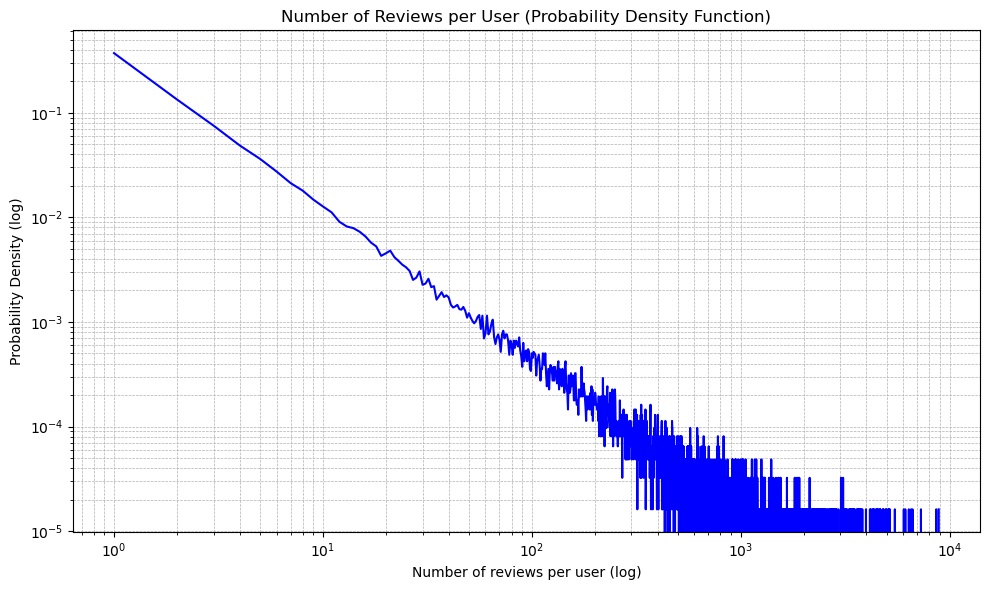

In [25]:
values = df_users['nbr_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values['nbr_ratings'].min(), values['nbr_ratings'].max() + 1)
values = values.set_index('nbr_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per user (log)')
ax.set_ylabel('Probability Density (log)')
ax.set_title('Number of Reviews per User (Probability Density Function)')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

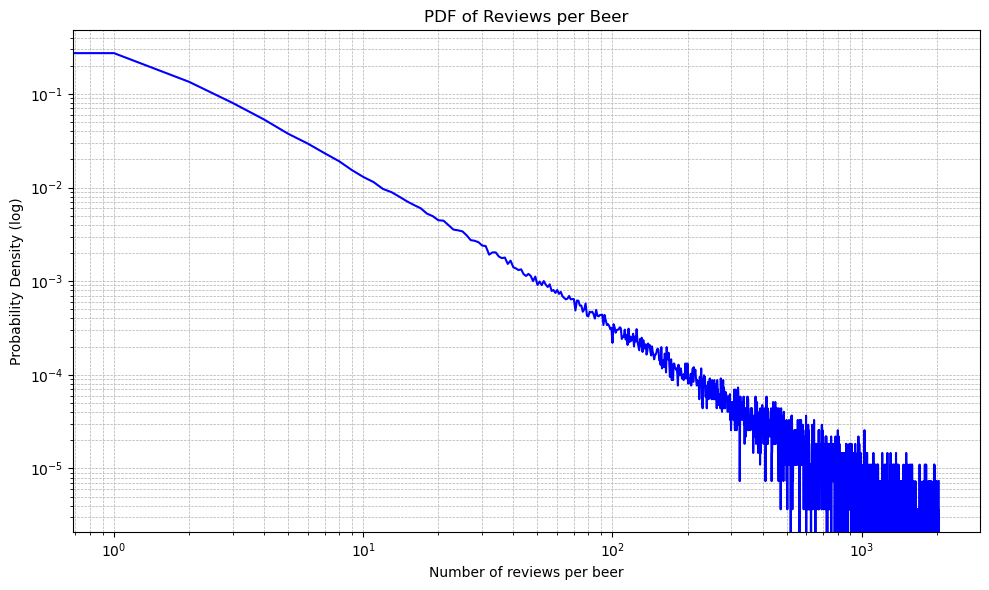

In [26]:
values = df_beers['nbr_ratings'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('nbr_ratings').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of reviews per beer')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Reviews per Beer')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

In these two cases, we indeed see that both plots are close to a straight line, with a lot of noise in the bottom-right corner. This is usual, as we have very few data points here and thus expect a lot of noise. In both cases, we are indeed dealing with a power law. This has some consequences, statistics like the mean, standard deviation, and variance are meaningless and should be avoided. Other metrics like the median should be used instead.

We can see if this holds for our number of beers per brewery as well.

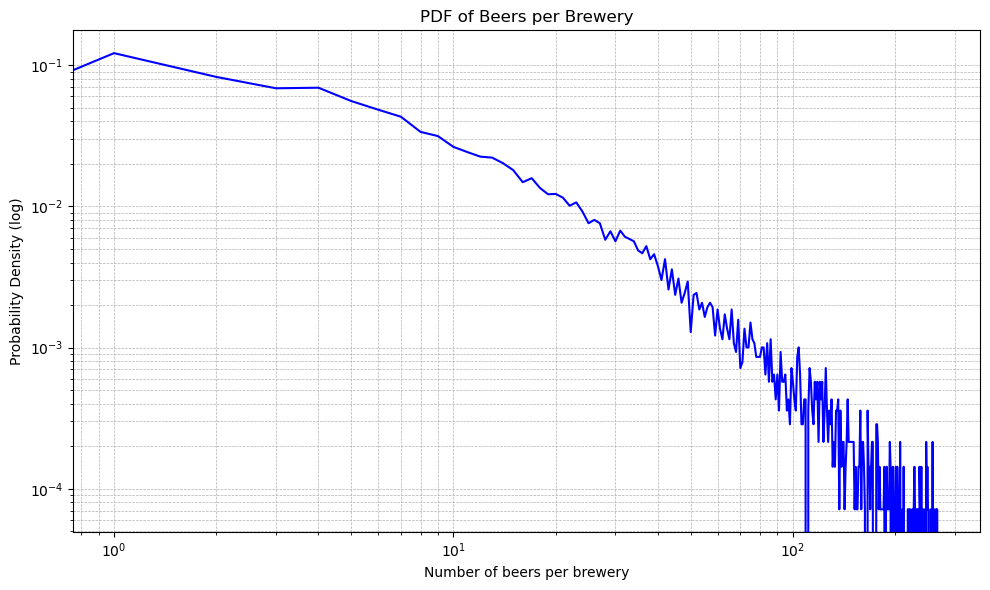

In [27]:
values = df_breweries['beers_count'].value_counts().to_pandas()

all_ratings = np.arange(values.index.min(), values.index.max() + 1)
values = values.set_index('beers_count').reindex(all_ratings)
values = values.fillna(0)  # Fill missing counts with 0

# Calculate PDF as normalized counts
pdf = values['count'] / values['count'].sum()

# Plotting the PDF
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(values.index, pdf, color='blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Number of beers per brewery')
ax.set_ylabel('Probability Density (log)')
ax.set_title('PDF of Beers per Brewery')
ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

This line is not a straight line. In this case we are therefore not dealing with a power law.

We can now do some initial exploration into potential correlations in our dataframe.

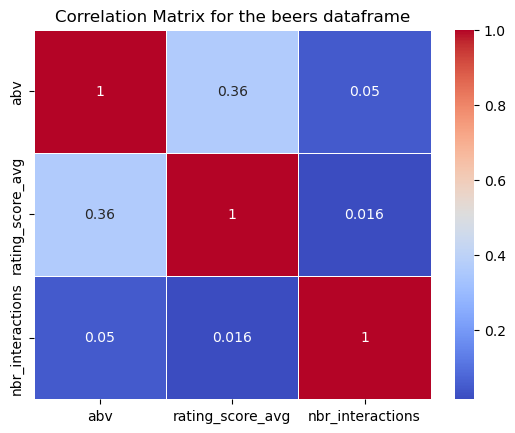

In [28]:
correlation_matrix = df_beers_corr.to_pandas().dropna().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix for the beers dataframe')
plt.show()

The correlation between ABV and the average rating is 0.3. This is a relatively weak but definitely noticable correlation. This is likely because users of the platform are experienced drinkers and prefer heavier beers. 

### Geographical analysis

##### User locations by country

As can be seen in the graph below, the largest continent in terms of user base is by far the North America.

Europe comes in second, and South America, Asia and Australia also have sizable audiences. 

Africa and Antarctica both have very few users. The Middle-East is also very devoid of any users. This makes sense, as many countries here have laws that ban the production and consumption of alcohol. 

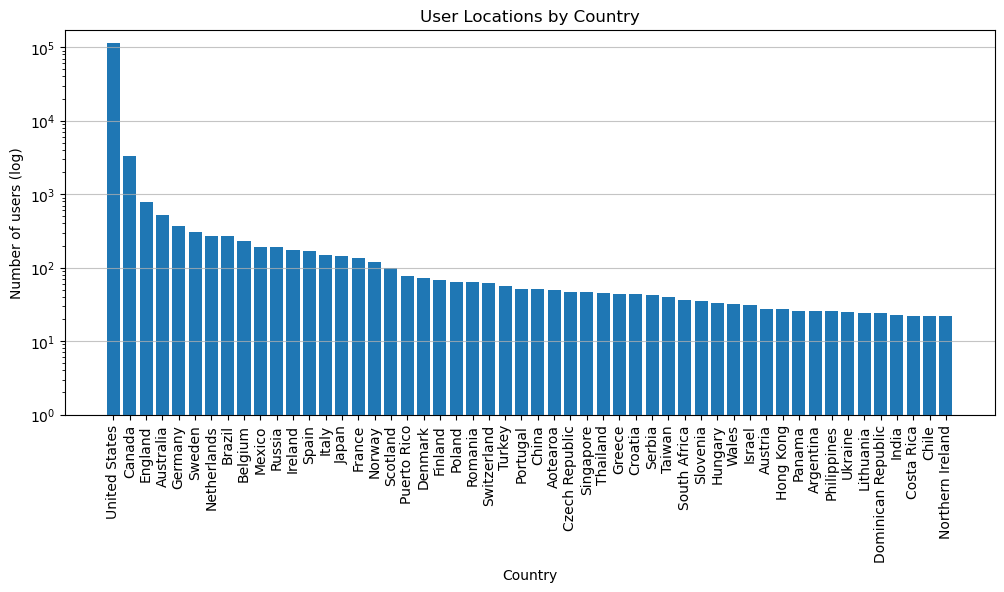

In [29]:
# Convert the polaris datastructure into a pandas dataframe
df_users_pd = df_users.to_pandas()

# Extract country names (split by ', ' and take the last part)
df_users_pd['country'] = df_users_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
country_counts = df_users_pd['country'].value_counts().reset_index()
country_counts_filtered = country_counts[country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 5))
plt.bar(country_counts_filtered['country'], country_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of users (log)')
plt.yscale('log')
plt.title('User Locations by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

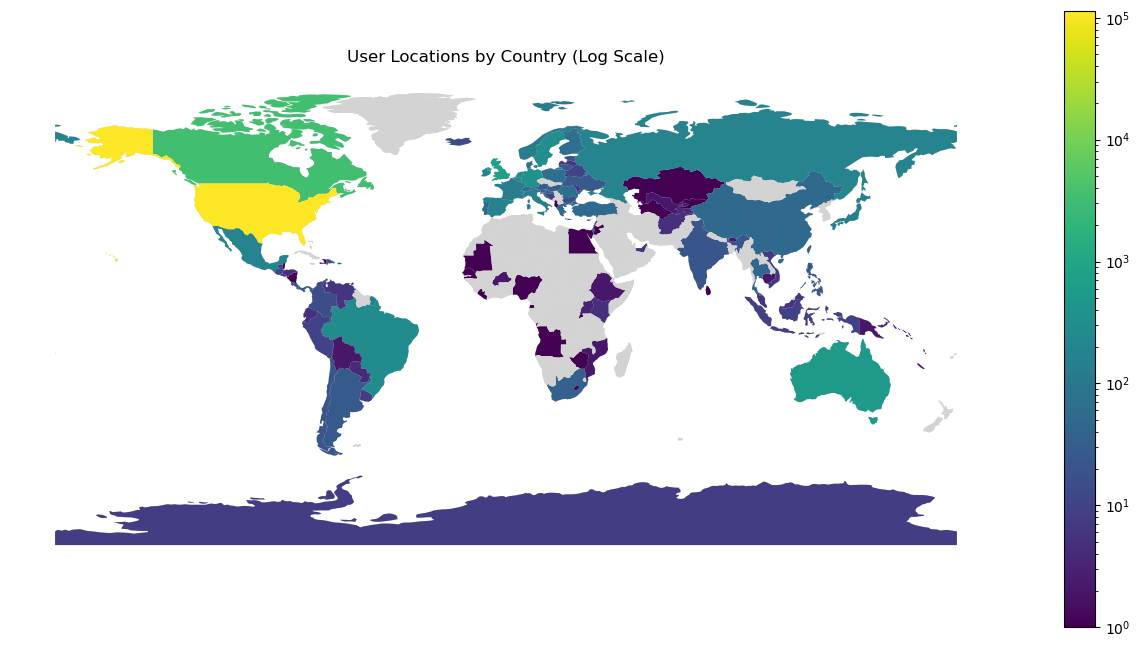

In [30]:
# Do some renaming of country names to match the map dataset
country_counts.loc[country_counts['country'] == 'United States', 'country'] = 'United States of America'
country_counts.loc[country_counts['country'] == 'England', 'country'] = 'United Kingdom'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('User Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Brewery locations by country

In the following two graphs we can see geographical location of breweries. This seems to be quite similar to the location of the users, but a bit flatter. This is likely because users will upload beers they have tried while traveling, and there is a ceiling to how many breweries you can enter into the database, as there are only so many breweries in a given country. 

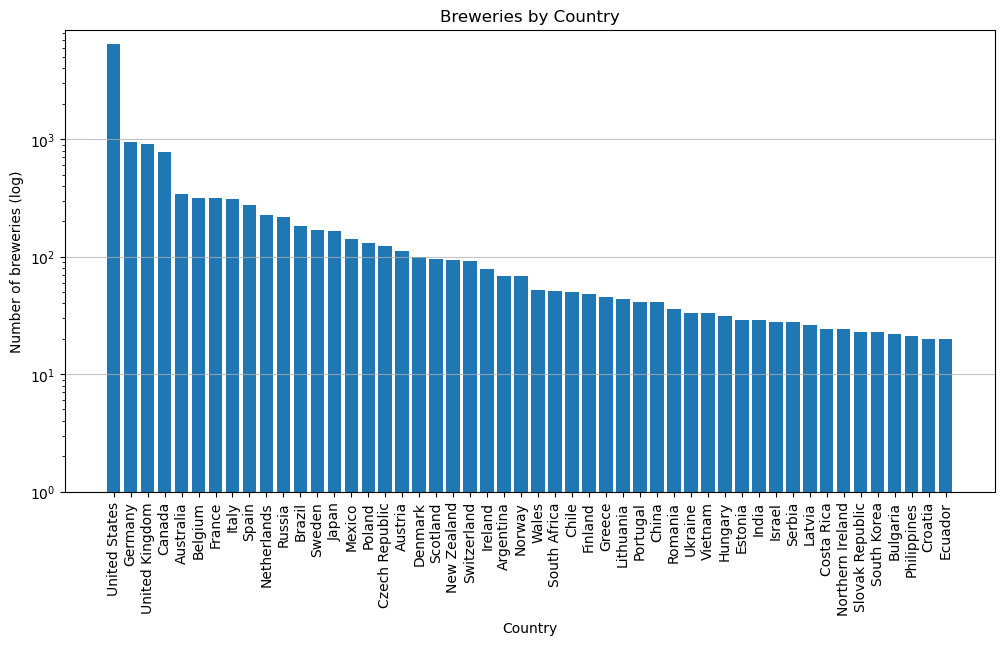

In [31]:
# Convert the polaris datastructure into a pandas dataframe
df_breweries_pd = df_breweries.to_pandas()
df_breweries_pd.loc[df_breweries_pd['location'] == 'England', 'location'] = 'United Kingdom'

# Extract country names (split by ', ' and take the last part)
df_breweries_pd['country'] = df_breweries_pd['location'].dropna().apply(lambda x: x.split(', ')[0])

# Count occurrences of each country and filter out countries with less than 20 occurrences
breweries_country_counts = df_breweries_pd['country'].value_counts().reset_index()
breweries_counts_filtered = breweries_country_counts[breweries_country_counts['count'] >= 20]

# Plot the countries
plt.figure(figsize=(12, 6))
plt.bar(breweries_counts_filtered['country'], breweries_counts_filtered['count'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.yscale('log')
plt.ylabel('Number of breweries (log)')
plt.title('Breweries by Country')
plt.grid(axis='y', alpha=0.75)
plt.ylim(bottom=1)
plt.show()

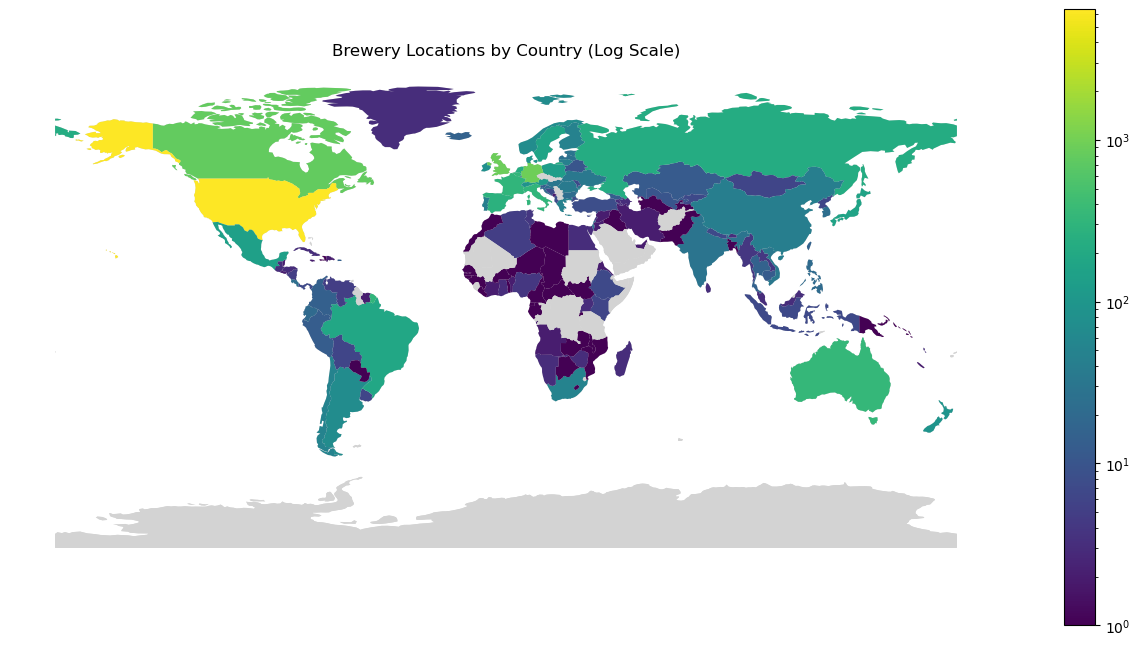

In [32]:
# Do some renaming of country names to match the map dataset
breweries_country_counts.loc[breweries_country_counts['country'] == 'United States', 'country'] = 'United States of America'

# Plot on a map the data
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip").rename(columns={'ADMIN': 'name'})
merged = world.merge(breweries_country_counts, how='left', left_on='name', right_on='country')

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray')  

# Plot with log scale normalization
merged.plot(
    column='count',
    ax=ax,
    legend=True,
    cmap='viridis',  
    norm=mcolors.LogNorm(vmin=1, vmax=merged['count'].max()), 
    missing_kwds={"color": "lightgray"}
)
ax.set_title('Brewery Locations by Country (Log Scale)')
plt.axis('off')
plt.show()

##### Discussion
Given that we have both the information regarding the brewery location and the users location we can link each review with the location of the beer and the origin country of users. 

### Temporal analysis

In this plot we investigate when users joined the website. It is clear to see that the site experiences its peak in 2014. We can also see that our data covers up to the year 2017. 

##### Users join date distribution

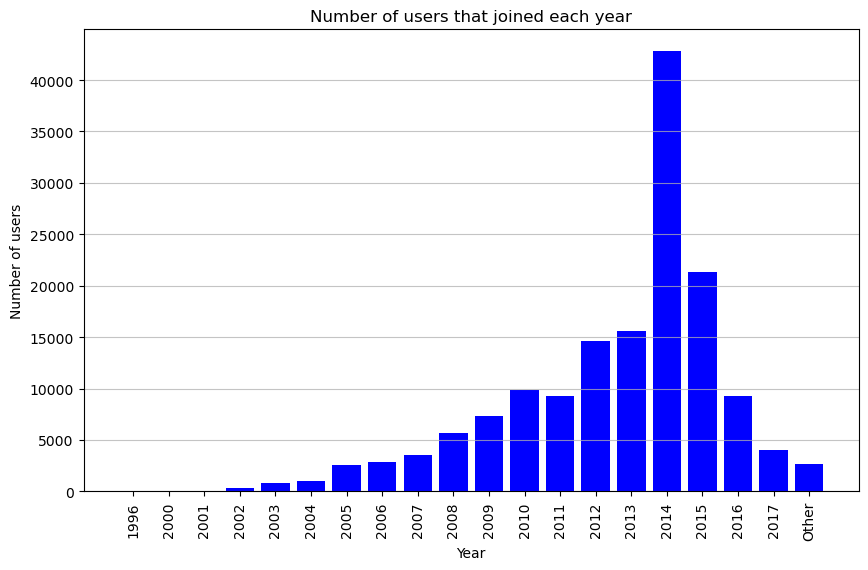

In [33]:
# Plot the number of users that joined each year
values = df_users_pd[df_users_pd['joined'].notna()]['joined'].dt.year.value_counts()

# Convert the index to string
values.index = values.index.astype(str)
values['Other'] = df_users_pd['joined'].isna().sum()

# Sort the values
values = values.sort_index()

# Display the plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(values.index, values.values, color='blue')
plt.xlabel('Year')
plt.xticks(values.index, rotation=90)
plt.ylabel('Number of users')
plt.title('Number of users that joined each year')
plt.grid(axis='y', alpha=0.75)
plt.show()

### MatchedBeers

### Discussion and future work